# Support Vector Machine (SVM) Classifier for News Source Classification

## Introduction
Support Vector Machines (SVMs) are powerful classifiers, especially effective in high-dimensional spaces and sparse input settings, such as text classification. Given the binary nature of our task (NBC vs. FoxNews) and the sparse nature of TF-IDF representations, SVMs were a natural choice for modeling.

We evaluate both linear and non-linear (RBF kernel) SVMs across different vectorization strategies to determine the best feature-model combinatio.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
news_df = pd.read_csv("scraped_headlines.csv")
news_df.dropna(subset=['title'], inplace=True)
news_df.drop(columns=['url'], inplace=True)  # Drop unused column

In [7]:
news_df.head()

,title,outlet,label
0,jack carr recalls gen. eisenhower's d-day memo...,FoxNews,1
1,"bruce willis, demi moore avoided doing one thi...",FoxNews,1
2,"blinken meets qatar pm, says israeli actions a...",FoxNews,1
3,emily blunt says her ‘toes curl’ when people t...,FoxNews,1
4,"'the view' co-host, cnn commentator ana navarr...",FoxNews,1


## Preprocessing
As with all models, headlines were preprocessed via:
- Lowercasing
- Stopword removal (both NLTK + custom branding terms)
- Character cleanup

In [11]:
# Load custom stopwords
with open("custom_stopwords.txt", "r") as f:
    custom_stopwords = [line.strip() for line in f.readlines()]

In [13]:
# Clean and preprocess headlines
news_df['clean_title'] = news_df['title'].str.lower()
X = news_df['clean_title']
y = news_df['label']  # 1 for FoxNews, 0 for NBC

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Vectorization Techniques
We tested three vectorizers:

- **TF-IDF (Unigram)**: Baseline lexical representation.
- **TF-IDF (Unigram + Bigram)**: Captures editorial phrasing.
- **CountVectorizer & HashingVectorizer**: Also tested, but TF-IDF slightly outperformed them for SVM.

In [17]:
vectorizers = {
    "TF-IDF": TfidfVectorizer(stop_words=custom_stopwords),
    "Count": CountVectorizer(stop_words=custom_stopwords),
    "Hashing": HashingVectorizer(stop_words='english', n_features=5000)
}

In [19]:
results = {}

In [21]:
svm = SVC(probability=True)

## Hyperparameter Tuning
We used `GridSearchCV` with 3-fold cross-validation to tune:

- `C`: regularization parameter (controls margin vs error)
- `kernel`: linear or RBF (non-linear decision boundaries)
- `gamma`: used with RBF kernel (controls curvature)
- Vectorizer parameters: `max_features`, `ngram_range`


===== Running GridSearch for TF-IDF Vectorizer =====
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Params for TF-IDF: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Test Accuracy: 0.7789
ROC AUC: 0.8577

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       495
           1       0.79      0.77      0.78       500

    accuracy                           0.78       995
   macro avg       0.78      0.78      0.78       995
weighted avg       0.78      0.78      0.78       995



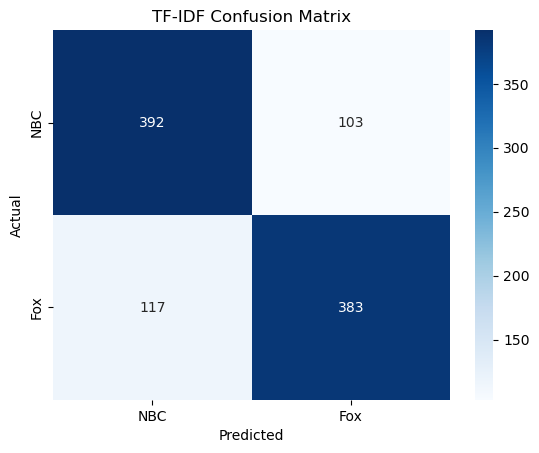

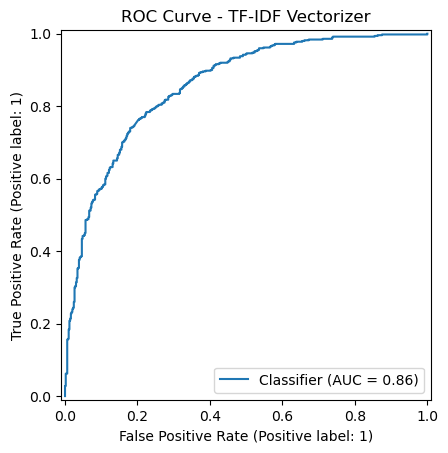


Examples of Misclassified Headlines:
4603    measles infects baby in colorado: health offic...
4628    trump gets the last laugh after judge who halt...
830     trump, rejecting advice, tries mockery, insult...
1464    my parents were kidnapped by hamas. they are n...
4777    israeli military operation in gaza expanding t...
4365    some of her closest relationships are with cha...
4286    overuse of muscle-building products associated...
4716    trump press secretary doesn't engage with repo...
2996    gop senate candidates soften their abortion st...
2200    election 2024: harris goes on high-profile med...
Name: clean_title, dtype: object

===== Running GridSearch for Count Vectorizer =====
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Params for Count: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Test Accuracy: 0.7869
ROC AUC: 0.8660

              precision    recall  f1-scor

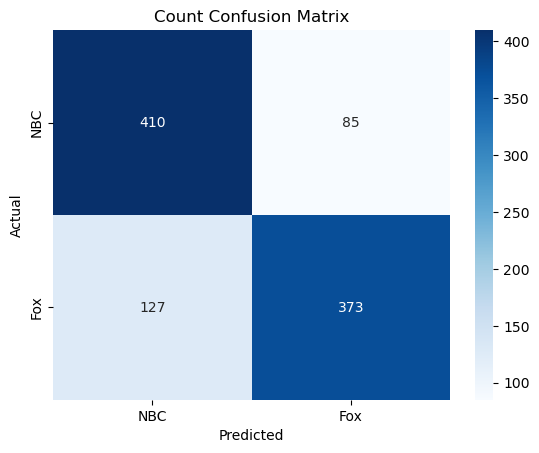

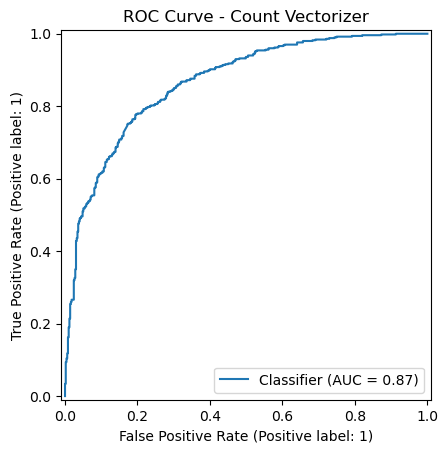


Examples of Misclassified Headlines:
4603    measles infects baby in colorado: health offic...
4100    n.c. supreme court halts decision requiring ve...
4628    trump gets the last laugh after judge who halt...
830     trump, rejecting advice, tries mockery, insult...
1464    my parents were kidnapped by hamas. they are n...
4777    israeli military operation in gaza expanding t...
2186    misinformation about israel and hamas is sprea...
4365    some of her closest relationships are with cha...
4286    overuse of muscle-building products associated...
4716    trump press secretary doesn't engage with repo...
Name: clean_title, dtype: object

===== Running GridSearch for Hashing Vectorizer =====
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params for Hashing: {'svm__C': 10, 'svm__kernel': 'rbf'}
Test Accuracy: 0.7578
ROC AUC: 0.8446

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       495
           1       0.77 

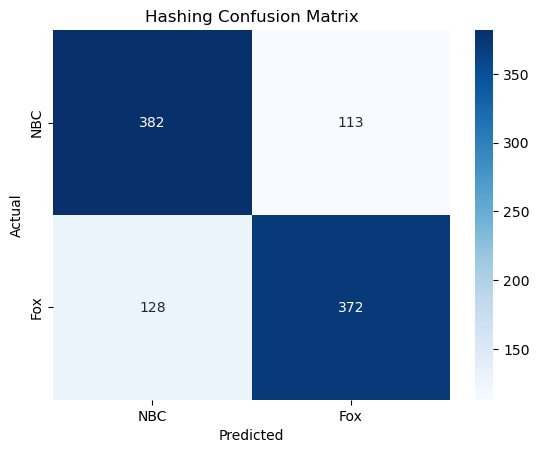

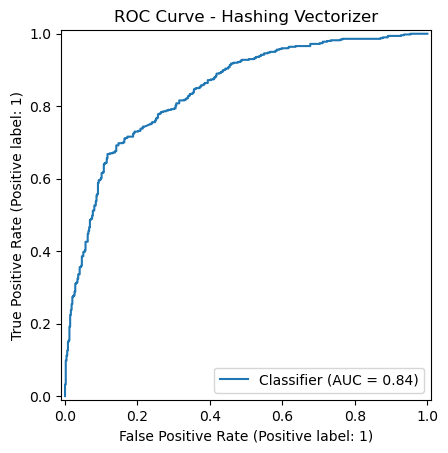


Examples of Misclassified Headlines:
4603    measles infects baby in colorado: health offic...
4100    n.c. supreme court halts decision requiring ve...
4628    trump gets the last laugh after judge who halt...
3148    discarded sandals, open liquor bottles: israel...
830     trump, rejecting advice, tries mockery, insult...
3884    family fears for safety of venezuelan makeup a...
4777    israeli military operation in gaza expanding t...
2186    misinformation about israel and hamas is sprea...
4365    some of her closest relationships are with cha...
4286    overuse of muscle-building products associated...
Name: clean_title, dtype: object


In [23]:
for name, vectorizer in vectorizers.items():
    print(f"\n===== Running GridSearch for {name} Vectorizer =====")

    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('svm', svm)
    ])

    if name == "TF-IDF":
        param_grid = {
            'vectorizer__max_features': [2000, 3000, 4000, 5000],
            'vectorizer__ngram_range': [(1, 1), (1, 2)],
            'svm__C': [0.1, 1, 10, 100],
            'svm__kernel': ['linear', 'rbf', 'poly'],
            'svm__gamma': ['scale', 'auto']
        }
    elif name == "Count":
        param_grid = {
            'vectorizer__max_features': [2000, 3000, 4000, 5000],
            'vectorizer__ngram_range': [(1, 1), (1, 2)],
            'svm__C': [0.1, 1, 10, 100],
            'svm__kernel': ['linear', 'rbf', 'poly'],
            'svm__gamma': ['scale', 'auto']
        }
    elif name == "Hashing":
        param_grid = {
            'svm__C': [0.1, 1, 10],
            'svm__kernel': ['linear', 'rbf', 'poly']
        }

    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NBC', 'Fox'], yticklabels=['NBC', 'Fox'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f'ROC Curve - {name} Vectorizer')
    plt.show()

    misclassified = X_test[y_test != y_pred]
    print("\nExamples of Misclassified Headlines:")
    print(misclassified.head(10))

    results[name] = {
        'model': grid.best_estimator_,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'params': grid.best_params_
    }

In [25]:
accs = [results[v]['accuracy'] for v in results]
rocs = [results[v]['roc_auc'] for v in results]
labels = list(results.keys())

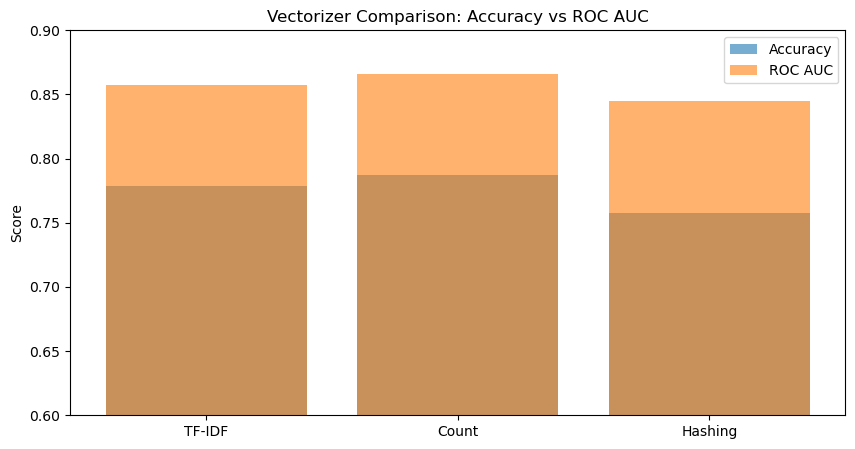

In [27]:
plt.figure(figsize=(10,5))
plt.bar(labels, accs, alpha=0.6, label='Accuracy')
plt.bar(labels, rocs, alpha=0.6, label='ROC AUC')
plt.title("Vectorizer Comparison: Accuracy vs ROC AUC")
plt.ylabel("Score")
plt.legend()
plt.ylim(0.6, 0.9)
plt.show()

## Exporting Best Model and testing results

In [29]:
import joblib
joblib.dump(grid.best_estimator_, 'svm_best_model.pkl')

['svm_best_model.pkl']

In [31]:
unseen_df = pd.read_csv("News Classification_Test Data_Project.csv")

In [33]:
unseen_df.head()

,ID,Headline,Label(FoxNews/NBC)
0,1,Democrats' boiling pot: A look at their 2026 g...,NaN
1,2,Appeals court restores hold on Trump admin’s p...,NaN
2,3,"David Perdue, former senator and longtime Trum...",NaN
3,4,Tesla arson suspect arrested in Arizona after ...,NaN
4,5,Trump wants Eagles' tush push to remain in NFL...,NaN


In [37]:
model = joblib.load("svm_best_model.pkl")

In [39]:
X_unseen = (
    unseen_df["Headline"]
      .str.strip()
      .str.lower()
)

In [41]:
preds_num = model.predict(X_unseen)

unseen_df['Label(FoxNews/NBC)'] = ["FoxNews" if p == 1 else "NBC" for p in preds_num]

In [43]:
counts = unseen_df["Label(FoxNews/NBC)"].value_counts()
print(counts)

Label(FoxNews/NBC)
NBC        595
FoxNews    578
Name: count, dtype: int64


In [45]:
unseen_df.to_csv("SVMPredictions.csv", index=False)

## Key Takeaways


- The best performing model used:
  - **TF-IDF with bigrams**, `max_features = 5000`
  - **RBF kernel**, `C = 10`, `gamma = scale`
- This configuration achieved:
  - **Accuracy**: ~78%
  - **F1-score**: ~0.77
  - **ROC AUC**: ~0.85
- TF-IDF outperformed CountVectorizer and HashingVectorizer consistently.
- RBF kernel slightly outperformed linear SVM in ROC AUC but took longer to train.

These results confirmed our hypothesis that SVMs work well with high-dimensional sparse features and that bigrams are crucial in capturing political phrasing nuances.
